# Analysis and Prediction of Heart Disease
### (Model Definition , Training and Evaluation)

## 4. Model Definition, Training and Evaluation :

In this notebook, we will select the model which is most appropriate for our usecase the model that is most appropriate for accurately predicting the possibility of a prediction of heart disease. 

### 4.1. Load Normalized Data from Object Storage :

In [1]:
# import required packages and libraries
import types
import pandas as pd
import numpy as np
import ibmos2spark

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190730152522-0002
KERNEL_ID = c58cc9c4-8c4a-475c-a766-10d37480203a


In [2]:
# @hidden_cell
credentials = {
    'endpoint': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'service_id': 'iam-ServiceId-39b8034e-49e4-4e3e-b6fd-44f01e7f35b9',
    'iam_service_endpoint': 'https://iam.eu-gb.bluemix.net/oidc/token',
    'api_key': 'iN3J17eRe8Mezyc57J4mtxTRFl-oey7Re0eCAwWgP_8T'
}

configuration_name = 'os_0dc47b3a85024faf8c9e361e756597e5_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')


from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_data = spark.read.parquet(cos.url('heart_normalized.parquet', 'definition-donotdelete-pr-cluwtgruaxvlbz'))
print("Number of records = ", df_data.count(), "\n")
df_data.createOrReplaceTempView('df')
df_data.show()

Number of records =  303 

+------+--------------------+
|target|            features|
+------+--------------------+
|     1|[0.0,0.0,0.0,0.0,...|
|     1|[0.0,0.0,0.0,1.0,...|
|     1|[1.0,0.0,1.0,0.0,...|
|     1|[0.0,0.0,1.0,0.0,...|
|     1|[1.0,1.0,0.0,0.0,...|
|     1|[0.0,1.0,0.0,0.0,...|
|     1|[1.0,0.0,1.0,0.0,...|
|     1|[0.0,0.0,1.0,0.0,...|
|     1|[0.0,0.0,0.0,1.0,...|
|     1|[0.0,0.0,0.0,1.0,...|
|     1|[0.0,1.0,0.0,0.0,...|
|     1|[1.0,0.0,0.0,1.0,...|
|     1|[0.0,0.0,1.0,0.0,...|
|     1|[0.0,0.0,0.0,0.0,...|
|     1|[1.0,0.0,0.0,0.0,...|
|     1|[1.0,0.0,0.0,1.0,...|
|     1|[1.0,0.0,0.0,1.0,...|
|     1|[1.0,0.0,0.0,0.0,...|
|     1|[0.0,1.0,0.0,0.0,...|
|     1|[1.0,0.0,0.0,0.0,...|
+------+--------------------+
only showing top 20 rows



Let's change the target column's name with label.

In [3]:
df_data_new = df_data.withColumnRenamed('target', 'label')
df_data_new.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[0.0,0.0,0.0,0.0,...|
|    1|[0.0,0.0,0.0,1.0,...|
|    1|[1.0,0.0,1.0,0.0,...|
|    1|[0.0,0.0,1.0,0.0,...|
|    1|[1.0,1.0,0.0,0.0,...|
|    1|[0.0,1.0,0.0,0.0,...|
|    1|[1.0,0.0,1.0,0.0,...|
|    1|[0.0,0.0,1.0,0.0,...|
|    1|[0.0,0.0,0.0,1.0,...|
|    1|[0.0,0.0,0.0,1.0,...|
|    1|[0.0,1.0,0.0,0.0,...|
|    1|[1.0,0.0,0.0,1.0,...|
|    1|[0.0,0.0,1.0,0.0,...|
|    1|[0.0,0.0,0.0,0.0,...|
|    1|[1.0,0.0,0.0,0.0,...|
|    1|[1.0,0.0,0.0,1.0,...|
|    1|[1.0,0.0,0.0,1.0,...|
|    1|[1.0,0.0,0.0,0.0,...|
|    1|[0.0,1.0,0.0,0.0,...|
|    1|[1.0,0.0,0.0,0.0,...|
+-----+--------------------+
only showing top 20 rows



Split the data into training and test datasets, 80% training data and 20% test data.

In [4]:
splits = df_data_new.randomSplit([0.8, 0.2])
df_train = splits[0] # training dataset
df_test = splits[1] # test dataset

In [5]:
df_train.createOrReplaceTempView('df_train')
spark.sql("select label, count(*) from df_train group by label").show()

+-----+--------+
|label|count(1)|
+-----+--------+
|    0|     112|
|    1|     127|
+-----+--------+



### 4.2. Model Selection :

### Gradient Boosted Trees :

Define our Supervised Machine Learning Model using the Gradient Boosted Trees Algorithm and train it using the training dataset.

In [6]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=10)

model = gbt.fit(df_train)
prediction1 = model.transform(df_train)

We will find accuracy as a measure of evaluation for our model.
Let's validate the training performance of our model against our training dataset.

In [7]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator().setMetricName('accuracy').setPredictionCol('prediction').setLabelCol('label')
print("GBT Training Accuracy")
evaluator.evaluate(prediction1)

GBT Training Accuracy


0.9790794979079498

The performance of our model against our training dataset appears to be pretty good at 0.96 (96%).Let's validate the performance of our model using test dataset.

In [8]:
model_test = gbt.fit(df_test)
prediction_test1 = model.transform(df_test)
print("GBT Validation Accuracy")
evaluator.evaluate(prediction_test1)

GBT Validation Accuracy


0.734375

### Random Forest Classification :

In [9]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)

model = rf.fit(df_train)
prediction2 = model.transform(df_train)

In [10]:
print("Random Forest Classification Training Accuracy")
evaluator.evaluate(prediction2)

Random Forest Classification Training Accuracy


0.9330543933054394

In [11]:
model_test = rf.fit(df_test)
prediction_test2 = model.transform(df_test)
print("Random Forest Classification Validation Accuracy")
evaluator.evaluate(prediction_test2)

Random Forest Classification Validation Accuracy


0.84375

### Naive Bayes Algorithm :

In [12]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial")

model = nb.fit(df_train)
prediction3 = model.transform(df_train)

In [13]:
print("Naive Bayes Algorithm Training Accuracy")
evaluator.evaluate(prediction3)

Naive Bayes Algorithm Training Accuracy


0.8410041841004184

In [14]:
model_test = nb.fit(df_test)
prediction_test3 = model.transform(df_test)
print("Naive Bayes Algorithm Validation Accuracy")
evaluator.evaluate(prediction_test3)

Naive Bayes Algorithm Validation Accuracy


0.890625

### Decision Tree Algorithm :

In [15]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

model = dt.fit(df_train)
prediction4 = model.transform(df_train)

In [16]:
print("Decision Tree Algorithm Training Accuracy")
evaluator.evaluate(prediction4)

Decision Tree Algorithm Training Accuracy


0.9205020920502092

In [17]:
model_test = dt.fit(df_test)
prediction_test4 = model.transform(df_test)
print("Decision Tree Algorithm Validation Accuracy")
evaluator.evaluate(prediction_test4)

Decision Tree Algorithm Validation Accuracy


0.734375

### Linear Support Vector Machine(SVM) :

In [18]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(maxIter=10, regParam=0.1)

model = lsvc.fit(df_train)
prediction5 = model.transform(df_train)

In [19]:
print("Support Vector Machine Algorithm Training Accuracy")
evaluator.evaluate(prediction5)

Support Vector Machine Algorithm Training Accuracy


0.8702928870292888

In [20]:
model_test = lsvc.fit(df_test)
prediction_test5 = model.transform(df_test)
print("Support Vector Machine Algorithm Validation Accuracy")
evaluator.evaluate(prediction_test5)

Support Vector Machine Algorithm Validation Accuracy


0.828125

### Comparison of  Algorithms :

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 

methods_accuracy = {
    "GBT":evaluator.evaluate(prediction_test1),
    "Random Forest" : evaluator.evaluate(prediction_test2),
    "Naive Bayes" : evaluator.evaluate(prediction_test3),
    "Decision Tree" : evaluator.evaluate(prediction_test4),
    "SVM" : evaluator.evaluate(prediction_test5),
    
}

/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


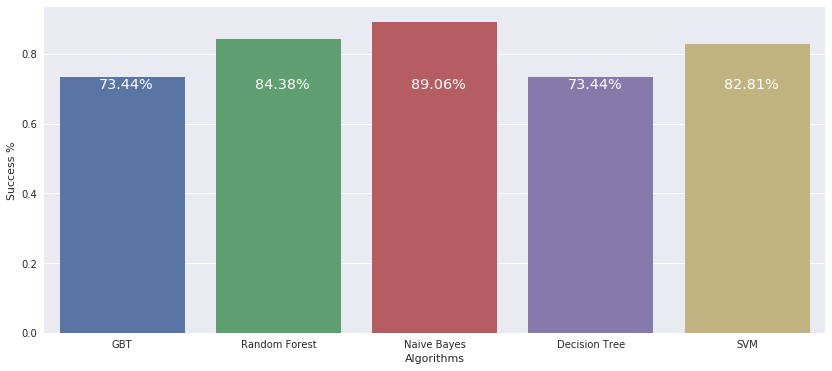

In [22]:
methods = ["GBT","Random Forest", "Naive Bayes", "Decision Tree", "SVM"]
accuracy = [evaluator.evaluate(prediction_test1), evaluator.evaluate(prediction_test2),evaluator.evaluate(prediction_test3),evaluator.evaluate(prediction_test4),evaluator.evaluate(prediction_test5)]

sns.set()
plt.figure(figsize=(14,6))
plt.ylabel("Success %")
plt.xlabel("Algorithms")
sns.barplot(x=methods, y=accuracy, palette="deep")

for line in range(len(methods)):
     plt.text(line-0.15, # x
              0.70, # y
             "{:.2f}%".format(accuracy[line]*100),
             horizontalalignment='left',
              size='large',
             color="white",
             )

        
###plt.savefig('ba.png',transparent=True)
      
plt.show()

So Naive Bayes is the best here and Random Forest is the 2nd best and, Decision tree and GBT are the worst algorithms.


### Neural networks :

In our data, we have created training and test datasets to be used for training and testing our model. However this data is represented as dataframes. Our Feed Forward Neural Network model here is implemented using Keras.
This Feed Forward Neural Network model expects the input and output dataset as arrays. So, let us first construct input and output data arrays from our training and test datasets.We will define a function which will take a dataframe as input and return the input array (features) and output array (label).

### Feed Forward Neural Network (MLP) :

In [23]:
def construct_arrays (df):
    # Initialize Input and Output arrays for the Data set
    X = []
    y = []
    
    # Convert dataframe from Spark DF to Pandas DF
    df_pd = df.toPandas()

    # Loop through dataframe and add data to input and output arrays
    for index, row in df_pd.iterrows():
        X.append(row[1])
        y.append(row[0])

    # Convery input and output data arrays from Python arrays to Numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return (X, y)

Pass the training and test data frames to the above function to obtain the respective input and output arrays containing the feature set and the label data.

In [24]:
X_train, y_train = construct_arrays(df_train)
print("Size of Training Features dataset: ", len(X_train))
print(X_train)
print("Size of Training Label dataset: ", len(y_train))
print(y_train)

X_test, y_test = construct_arrays (df_test)
print("Size of Test Features dataset: ", len(X_test))
print(X_test)
print("Size of Test Label dataset: ", len(y_test))
print(y_test)

Size of Training Features dataset:  239
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 ..., 
 [ 1.  1.  0. ...,  0.  0.  1.]
 [ 1.  1.  0. ...,  0.  0.  1.]
 [ 1.  1.  0. ...,  0.  0.  1.]]
Size of Training Label dataset:  239
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Size of Test Features dataset:  64
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  1.  0. ...,  0.  0.  1.]
 ..., 
 [ 1.  1.  0. ...,  0.  0.  1.]
 [ 1.  1.  0. ...,  0.  0.  1.]
 [ 1.  1.  0. ...,  0.  0.  1.]]
Si

### Model Definition, Training and Evaluation of Deep Learning :

Define our Deep Learning Model using the Feed Forward Neural Network (Multilayer Perceptron) Algorithm and then train and evaluate the model using the training and test/validation datasets.

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

# Define a Multilayer Perceptron (MLP) Model using Keras
model = Sequential()
model.add(Dense(21, input_dim = 21, kernel_initializer = 'normal', activation = 'relu')) # input Layer
model.add(Dense(1, kernel_initializer = 'normal', activation = 'sigmoid')) # Output Layer

# Compile our model
model.compile(loss = 'binary_crossentropy', optimizer = 'adadelta', metrics = ['accuracy'])

# Train our model
model.fit(X_train, y_train, epochs = 20, batch_size = 5, verbose = 1, validation_data = (X_test, y_test))

# Evaluate our model
score = model.evaluate(X_test, y_test, verbose = 0)
print(score)

Using TensorFlow backend.


Train on 239 samples, validate on 64 samples
Epoch 1/20
239/239 [==============================] - 0s 882us/step - loss: 0.6758 - acc: 0.6025 - val_loss: 0.6298 - val_acc: 0.7656
Epoch 2/20
239/239 [==============================] - 0s 412us/step - loss: 0.5779 - acc: 0.7824 - val_loss: 0.4595 - val_acc: 0.8281
Epoch 3/20
239/239 [==============================] - 0s 338us/step - loss: 0.4457 - acc: 0.8494 - val_loss: 0.3610 - val_acc: 0.8594
Epoch 4/20
239/239 [==============================] - 0s 332us/step - loss: 0.3769 - acc: 0.8368 - val_loss: 0.3321 - val_acc: 0.8438
Epoch 5/20
239/239 [==============================] - 0s 365us/step - loss: 0.3500 - acc: 0.8494 - val_loss: 0.3781 - val_acc: 0.8438
Epoch 6/20
239/239 [==============================] - 0s 420us/step - loss: 0.3383 - acc: 0.8494 - val_loss: 0.3432 - val_acc: 0.8594
Epoch 7/20
239/239 [==============================] - 0s 537us/step - loss: 0.3377 - acc: 0.8577 - val_loss: 0.3444 - val_acc: 0.8594
Epoch 8/20
239/23

The accuracy of our Feed Forward Neural Network is not bad.

Accurancy : %84

In [32]:
accrDL = 0.84375

### Comparison of All Algorithms :

In [26]:
methods_accuracyy = {
    "GBT":evaluator.evaluate(prediction_test1),
    "Random Forest" : evaluator.evaluate(prediction_test2),
    "Naive Bayes" : evaluator.evaluate(prediction_test3),
    "Decision Tree" : evaluator.evaluate(prediction_test4),
    "SVM" : evaluator.evaluate(prediction_test5),
    "Feed Forward Neural Network" : accrDL 
}


/opt/ibm/conda/miniconda3/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


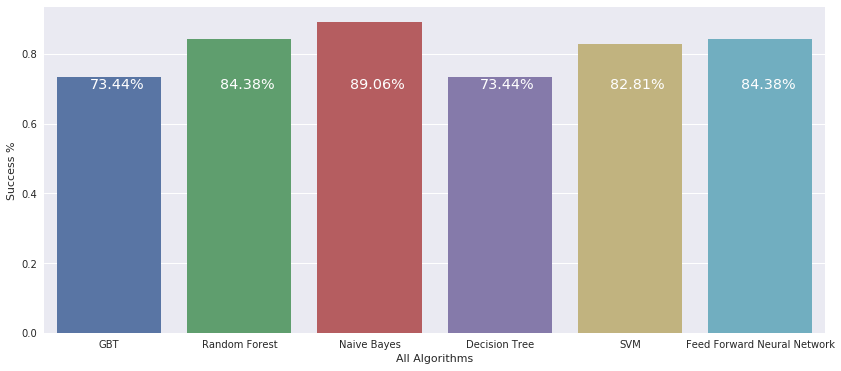

In [34]:
methods = ["GBT","Random Forest", "Naive Bayes", "Decision Tree", "SVM", "Feed Forward Neural Network"]
accuracy = [evaluator.evaluate(prediction_test1), evaluator.evaluate(prediction_test2),evaluator.evaluate(prediction_test3),evaluator.evaluate(prediction_test4),evaluator.evaluate(prediction_test5), accrDL]

sns.set()
plt.figure(figsize=(14,6))
plt.ylabel("Success %")
plt.xlabel("All Algorithms")
sns.barplot(x=methods, y=accuracy, palette="deep")

for line in range(len(methods)):
     plt.text(line-0.15, # x
              0.70, # y
             "{:.2f}%".format(accuracy[line]*100),
             horizontalalignment='left',
              size='large',
             color="white",
             )

        
###plt.savefig('ba.png',transparent=True)
      
plt.show()